# Neural Autoregressive Flows

Ok, so I thought I was having issues with the MAF not being expressive enough, so I started digging into this other architectures, and here I'm just trying to understand the syntax from the repos that they published with the NAF paper.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import StandardScaler

import os
import sys
sys.path.append("../../naf_examples")
sys.path.append("../../torchkit")
sys.path.append("../../torchkit/torchkit")
sys.path.append("../../NAF")

sys.path.append("../code")
from AnalysisUtils import *

import naf
from naf.distributions import Distr
import torch
from torch.autograd import Variable

%load_ext autoreload
%autoreload 2

Basically this notebook just starts off trying to duplicate [this example](https://github.com/CW-Huang/naf_examples)

In [3]:
distr = naf.distributions.SwissRoll(0.5)
res = 200
rng = [(-5,5),(-5,5)]


Iteration: [ 100/2000] loss: 4.42584133
Iteration: [ 200/2000] loss: 3.90635967
Iteration: [ 300/2000] loss: 3.50193787
Iteration: [ 400/2000] loss: 3.27274418
Iteration: [ 500/2000] loss: 3.15353608
Iteration: [ 600/2000] loss: 3.29155660
Iteration: [ 700/2000] loss: 2.99082184
Iteration: [ 800/2000] loss: 2.96135521
Iteration: [ 900/2000] loss: 3.21808767
Iteration: [1000/2000] loss: 3.37347341
Iteration: [1100/2000] loss: 3.21829271
Iteration: [1200/2000] loss: 3.22136450
Iteration: [1300/2000] loss: 3.06143928
Iteration: [1400/2000] loss: 3.20806599
Iteration: [1500/2000] loss: 3.06427741
Iteration: [1600/2000] loss: 3.13560915
Iteration: [1700/2000] loss: 3.04042912
Iteration: [1800/2000] loss: 2.95976257
Iteration: [1900/2000] loss: 2.98170018
Iteration: [2000/2000] loss: 3.11540103


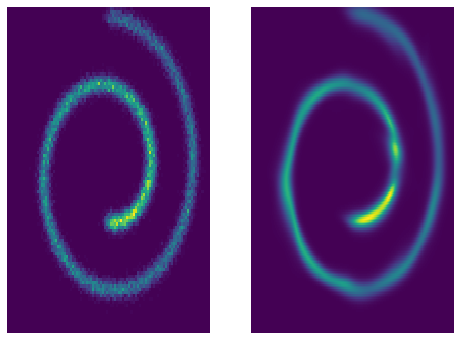

In [5]:
# DSF
denaf = naf.DensityEstimator(flowtype=1)
denaf.fit(distr, 2000)
fig = naf.visualize2D(distr, denaf, res=res, rng=rng)

Iteration: [ 100/2000] loss: 4.53193140
Iteration: [ 200/2000] loss: 4.34548235
Iteration: [ 300/2000] loss: 4.40279913
Iteration: [ 400/2000] loss: 4.28141499
Iteration: [ 500/2000] loss: 4.18890715
Iteration: [ 600/2000] loss: 4.21015310
Iteration: [ 700/2000] loss: 4.25833797
Iteration: [ 800/2000] loss: 4.20077467
Iteration: [ 900/2000] loss: 4.06184816
Iteration: [1000/2000] loss: 4.22978401
Iteration: [1100/2000] loss: 4.12596083
Iteration: [1200/2000] loss: 4.21933651
Iteration: [1300/2000] loss: 4.23869276
Iteration: [1400/2000] loss: 4.13370275
Iteration: [1500/2000] loss: 4.30690098
Iteration: [1600/2000] loss: 4.11434221
Iteration: [1700/2000] loss: 4.19160795
Iteration: [1800/2000] loss: 4.36549664
Iteration: [1900/2000] loss: 4.25241184
Iteration: [2000/2000] loss: 4.24976683


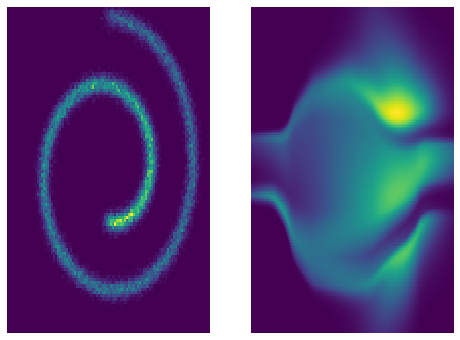

In [6]:
# IAF
denaf = naf.DensityEstimator(flowtype=0)
denaf.fit(distr, 2000)
fig = naf.visualize2D(distr, denaf, res=res, rng=rng)

This is *absolutely awesome*, and **so exciting**!! I guess at this point I'm ready to plug and play with some other distribution.

## Playing with $m_{hh}$ in the 2b sideband

**Step 1:** Need to put my distribution in a format where it's readable by the `.fit` function.

In [2]:
data_fileName = "../../public/hh4b/nanoNtuples/data16/data16_with_weights.root"
df = nanoToDf(data_fileName.format("topo"),ttree='fullmassplane')

fullmassplane


In [40]:
class myDataset(Distr):
    
    hasenergyf = False
    hassplr = True
    
    def __init__(self, Ntrain=10000, cols=['m_hh']):

        d = len(cols)
        
        mask = (df.kinematic_region == 2) & (df.ntag == 2)
        m_hh = df.loc[mask,cols].values[:Ntrain].reshape(-1, d)

        # Take the log
        m_hh = np.log(m_hh)

        # Normalize
        scalarX = StandardScaler()
        scalarX.fit(m_hh)

        self.x = scalarX.transform(m_hh,copy=True).reshape(-1,d)
        self.scalarX = scalarX
        
    def sampler(self, n):
        return torch.from_numpy( self.x.astype('float32') )


In [4]:
Ntrain = 10000
x = myDataset(Ntrain)

**Step 2:** Define and train the model

In [5]:
denaf = naf.DensityEstimator(flowtype=1, dim=1, n=Ntrain)

In [6]:
x.x.shape

(10000, 1)

In [7]:
denaf.fit(x, 700)

Iteration: [ 100/ 700] loss: 3.15192199
Iteration: [ 200/ 700] loss: 3.15133405
Iteration: [ 300/ 700] loss: 3.15000224
Iteration: [ 400/ 700] loss: 3.14902258
Iteration: [ 500/ 700] loss: 3.15244222
Iteration: [ 600/ 700] loss: 3.14653015
Iteration: [ 700/ 700] loss: 3.14638186


Note (for tomorrow): it would also be nice to visualize these losses, train w/ early stopping, etc.

**Step 3:** Visualize the results

In [8]:
res = 200

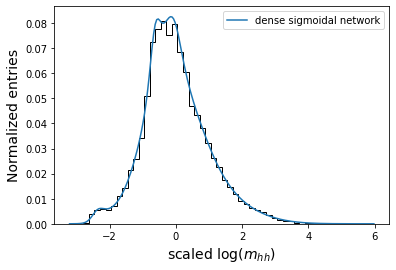

In [9]:
plt.hist(x.x,50,histtype='step',color='k',weights=np.ones_like(x.x)*1e-4)

xlim = plt.xlim()

res=200
xi = np.linspace(*xlim,res)

X = Variable(torch.from_numpy(xi.reshape(-1,1).astype('float32')))

context = Variable(torch.FloatTensor(res, 1).zero_()) + 2.0
lgd = Variable(torch.FloatTensor(res).zero_())
zeros = Variable(torch.FloatTensor(res, 2).zero_())

Z = denaf.density(X,lgd,context,zeros).data.numpy()

plt.plot(xi,np.exp(Z),label='dense sigmoidal network')

plt.legend()
plt.xlabel('scaled $\log ( m_{hh} )$',fontsize=14)
plt.ylabel('Normalized entries',fontsize=14)

plt.show()

**Q:** What are these `context`, `lgd`, and `zeros` variables, and why are we adding 2 to the context?

- context is the context,
- lgd is the log determinant
- zeros is just a tensor of zeros with a given shape


Wow!! To me, this looks like a pretty good fit! (Maybe I should try sampling from it as well, although I'm not 100% sure if this is something that I can do or not?)

**Next step:** Transform back to the real space and look at the JSD

In [10]:
mask = (df.kinematic_region == 2) & (df.ntag == 2)
m_hh = df.loc[mask,'m_hh'].values[:Ntrain]

Ok, so when I'm transforming distributions, I also need to be careful about

$$p_X(x) = p_U(u) \left|\frac{dx}{du}\right|^{-1}$$

My pre-processing xformation was

$$x=\exp \left( \frac{u-\mu}{\sigma} \right)$$

This means $u = \mu + \sigma \log x$, so

$$\frac{du}{dx} = \frac{\sigma}{x}$$


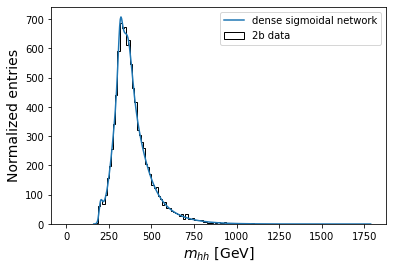

In [33]:
Nbins = 100
xlim = (0,1250)
n,_,_ = plt.hist(m_hh,Nbins,xlim,histtype='step',color='k',label='2b data')#, 
                 #weights=np.ones_like(x.x)*1e-4)

t = x.scalarX.inverse_transform(xi)
t = np.exp(t) 

px = np.exp(Z)*sigma/t
dt = t[1:] - t[:-1]
mid_px = 0.5 * (px[1:] + px[:-1])

N = Ntrain*(xlim[1]-xlim[0]) / (np.sum(dt * mid_px)*Nbins)

plt.plot(t,N*px,label='dense sigmoidal network',color='C0')

plt.legend()
plt.xlabel('$m_{hh}$ [GeV]',fontsize=14)
plt.ylabel('Normalized entries',fontsize=14)

plt.show()

Awesome, I have a method that is sufficiently flexible now that I can directly model $m_{hh}$ in the SB without resorting to reweighting techniques!

I *think* the next step is looking into some conditional methods... but first I want to follow-up and understand the NAF architecture better!

Ok, so I found a paper on [conditional NAFs](https://arxiv.org/pdf/1912.08111.pdf), but I think it would be faster for me first to try to just model in 3d all of these variables (in the SB) masking the massplane, and then check the extrapolation into the CR. 

(Note, with my model above, I won't have any difference in the $m_{hh}$ shapes between the SR and CR, because I haven't baked the location in the massplane into the model *anywhere*)

In [62]:
cols = ['m_h1','m_h2','m_hh']
y = myDataset(Ntrain, cols)
naf_3d = naf.DensityEstimator(flowtype=1, dim=len(cols), n=Ntrain)
naf_3d.fit(y, 700)

Iteration: [ 100/ 700] loss: 3.04240465
Iteration: [ 200/ 700] loss: 3.01933813
Iteration: [ 300/ 700] loss: 3.00465751
Iteration: [ 400/ 700] loss: 2.99521255
Iteration: [ 500/ 700] loss: 2.98672342
Iteration: [ 600/ 700] loss: 2.97863150
Iteration: [ 700/ 700] loss: 2.96292090


In [63]:
?np.meshgrid

-2.069076328196713 1.4284103184834551


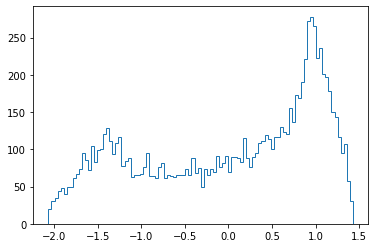

-1.8283788874235465 1.5588641406464272


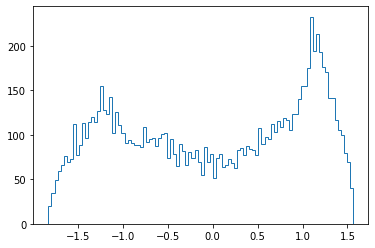

-2.7915377889369974 5.561245011881247


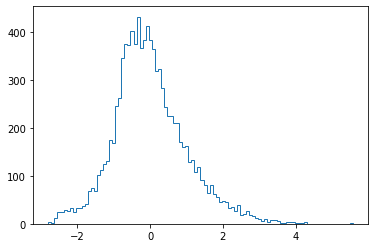

In [67]:
for i in range(3):
    print(np.min(y.x[:,i]),np.max(y.x[:,i]))
    plt.figure()
    plt.hist(y.x[:,i],100,histtype='step')
    plt.show()

I think it might also be nice to visualize how we've fit the sideband at this point?

In [65]:
xlim

(-3.2091769289779095, 5.978884151922159)

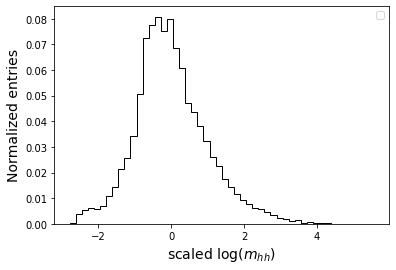

In [64]:
plt.hist(y.x[:,-1],50,histtype='step',color='k',weights=np.ones_like(y.x[:,-1])*1e-4)

xlim = plt.xlim()

res=200
# xi = np.linspace(*xlim,res)

# X = Variable(torch.from_numpy(xi.reshape(-1,1).astype('float32')))

# context = Variable(torch.FloatTensor(res, 1).zero_()) + 2.0
# lgd = Variable(torch.FloatTensor(res).zero_())
# zeros = Variable(torch.FloatTensor(res, 2).zero_())

# Z = denaf.density(X,lgd,context,zeros).data.numpy()

# plt.plot(xi,np.exp(Z),label='dense sigmoidal network')

plt.legend()
plt.xlabel('scaled $\log ( m_{hh} )$',fontsize=14)
plt.ylabel('Normalized entries',fontsize=14)

plt.show()

In [ ]:
Nbins = 100
xlim = (0,1250)
n,_,_ = plt.hist(m_hh,Nbins,xlim,histtype='step',color='k',label='2b data')#, 
                 #weights=np.ones_like(x.x)*1e-4)

t = x.scalarX.inverse_transform(xi)
t = np.exp(t) 

px = np.exp(Z)*sigma/t
dt = t[1:] - t[:-1]
mid_px = 0.5 * (px[1:] + px[:-1])

N = Ntrain*(xlim[1]-xlim[0]) / (np.sum(dt * mid_px)*Nbins)

plt.plot(t,N*px,label='dense sigmoidal network',color='C0')

plt.legend()
plt.xlabel('$m_{hh}$ [GeV]',fontsize=14)
plt.ylabel('Normalized entries',fontsize=14)

plt.show()

In [58]:
y.x

array([[ 0.85344891, -0.67545281],
       [-1.92815018,  0.41084377],
       [-1.79926155, -1.38622262],
       ...,
       [ 0.27600194, -0.06308764],
       [ 0.51422161, -1.25670091],
       [ 0.99920804, -0.40243106]])

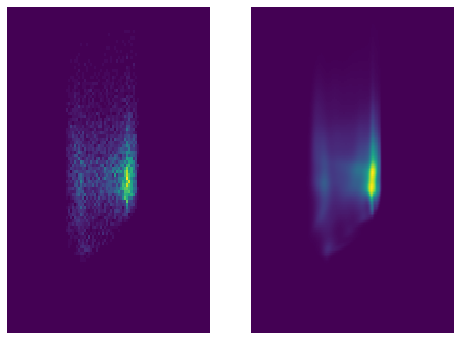

In [59]:
fig = naf.visualize2D(y, naf_3d, res=res, rng=rng)

Ok, it's modelling both dimensions beautifully... but this isn't what I wanted atm!!

## Hyper-Conditioned Neural Autoregressive Flow (HCNAF)